### Distance distribution from variant to tss


the idea is that the pcqtls are maybe picking up on more distant signals/regulatory elements?


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import os
import ast
import re

from tqdm.auto import tqdm  # for notebooks

# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()

import matplotlib as mpl
#mpl.rcParams['figure.dpi']= 1000
mpl.rcParams['figure.dpi']= 100

prefix = '/home/klawren/oak/pcqtls'

import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')
from notebook_helper_functions import *
from annotate_clusters import *


In [2]:
# get outputs from a config file
prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config/proteincoding_main.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

tissue_id_path = config['tissue_id_path']
overlap_output_dir = config['overlap_output_dir']
pc_output_dir = config['pc_output_dir']

# load in the tissue ids 
tissue_df = pd.read_csv(f"{prefix}/{tissue_id_path}", header=0)
tissue_ids = list(tissue_df['Tissue'])

In [3]:
# load in the data from all tissues
overlap_dfs=[]
for i in range(len(tissue_ids)):
    tissue_id = tissue_ids[i]
    overlap_dfs.append(pd.read_csv(f'{prefix}/{overlap_output_dir}/{tissue_id}.v8.overlap.txt', sep='\t'))
overlap_df = pd.concat([df.assign(tissue_id=n) for df, n in zip(overlap_dfs, tissue_ids)])
overlap_df.reset_index(inplace=True, drop=True)


# for debugging, try with a single tissue 
#overlap_df = pd.read_csv(f'{prefix}/output/overlap/{tissue_id}.v8.overlap.txt', sep='\t')

In [8]:
# add pc 1 and 2 specific columns
def count_pc(id_list, pc_num):
    return sum([f'pc{pc_num}' in phenotype_id for phenotype_id in id_list])

overlap_df['num_pc1_overlap'] = overlap_df['pc_overlap'].apply(ast.literal_eval).apply(count_pc, pc_num=1)
overlap_df['num_pc2_overlap'] = overlap_df['pc_overlap'].apply(ast.literal_eval).apply(count_pc, pc_num=2)
overlap_df['num_pc1_samelead'] = overlap_df['pc_samelead'].apply(ast.literal_eval).apply(count_pc, pc_num=1)
overlap_df['num_pc2_samelead'] = overlap_df['pc_samelead'].apply(ast.literal_eval).apply(count_pc, pc_num=2)

# add in general pc id column
overlap_df['pc_num'] = np.where(overlap_df['orig_cs_dataset']=='pc_qtl',  overlap_df['cs_full_id'].str.split('_').str[-2].str.strip('pc'), 0)
overlap_df['pc_num'] = overlap_df['pc_num'].astype(int)
# add in cluster size
overlap_df['cluster_size'] = overlap_df['cluster_id'].str.split('_').apply(len)

# add in the variant position as a column
overlap_df['lead_variant_pos'] = overlap_df['lead_variant_id'].str.split('_').str[1].astype(int)

# TSS distance

In [9]:
# load in the gene information (start and strand are what I need)
gid_gencode, full_gencode = load_gencode()

In [10]:
# distance to whichever gene in the cluster is closest
def get_tss(row):
    cluster_gene_df = gid_gencode.loc[row['cluster_id'].split('_')]
    starts = cluster_gene_df['tss_start'].values
    distances = row['lead_variant_pos'] - starts
    # return smallest absolute value distance
    idx = np.argmin(abs(distances))
    # make relative to gene orientation
    if cluster_gene_df.iloc[idx]['strand'] == '-':
        return -distances[idx]
    else:
        return distances[idx]
    
# for just the egenes, get the egene start that actually matched the gene of interest
def get_egene_distance(row):
    assert row['orig_cs_dataset'] =='control_eqtl'
    egene = row['cs_full_id'].split('_e_')[1]
    gene_df = gid_gencode.loc[egene]
    #gene_df = full_gencode[full_gencode['transcript_id']==egene].iloc[0]
    # make relative to gene orientation
    if gene_df['strand'] == '-':
        return -(row['lead_variant_pos']-gene_df.tss_start)
    else:
        return row['lead_variant_pos']-gene_df.tss_start

In [11]:
# annotate all egenes and pcqtls with the distance to the closest gene in the cluster
overlap_df['cluster_min_distance'] = overlap_df.progress_apply(get_tss, axis=1)

# optionally, write out with distances 
#overlap_df.to_csv(f'{prefix}/{overlap_output_dir}/all.overlap.distances.txt', sep='\t')

  0%|          | 0/41146 [00:00<?, ?it/s]

In [12]:
# annotate all eqtls with the distance to their egene
e_overlap_df = overlap_df[overlap_df['orig_cs_dataset']=='control_eqtl']
e_overlap_df['egene_distance'] = e_overlap_df.progress_apply(get_egene_distance, axis=1)

  0%|          | 0/20942 [00:00<?, ?it/s]

/local/scratch/klawren/slrmtmp.46646254/ipykernel_19975/3634702297.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  e_overlap_df['egene_distance'] = e_overlap_df.progress_apply(get_egene_distance, axis=1)


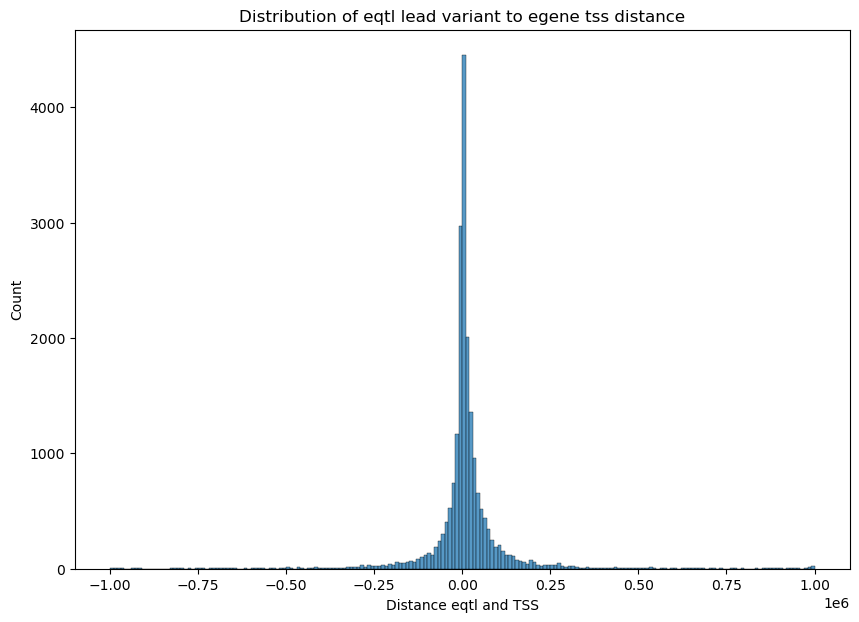

In [13]:
# plot for just the egene distances
fig, ax = plt.subplots(figsize=(10,7))
# you can ocasionally get variants further than this due to large cluster sizes
# clipped for clarity 
sns.histplot(e_overlap_df['egene_distance'].clip(-1000000, 1000000), bins=200, ax=ax)
ax.set_xlabel('Distance eqtl and TSS')
ax.set_title('Distribution of eqtl lead variant to egene tss distance')
plt.show()

In [14]:
# a dataset that puts egenes in twice, once with a distance to their egene and once with a distance to the closest gene in the cluster
joined=pd.DataFrame({'distance': np.concatenate([overlap_df['cluster_min_distance'], 
                                                 e_overlap_df['egene_distance']]), 
              'dataset':np.concatenate([overlap_df['orig_cs_dataset'], 
                                        pd.Series(['eqtl_egene']*len(e_overlap_df))])})
joined.loc[joined['dataset']=='control_eqtl','dataset'] ='eqtl_closest_cluster_gene'

# plotable distances 
joined['clip_distance'] = joined['distance'].clip(-1000000, 1000000)
joined['abs_clip_distance_kb'] = joined['clip_distance'].apply(abs) /1000

Text(0.5, 1.0, 'Cumulative distribution of distances from lead variant position to closest cluster tss')

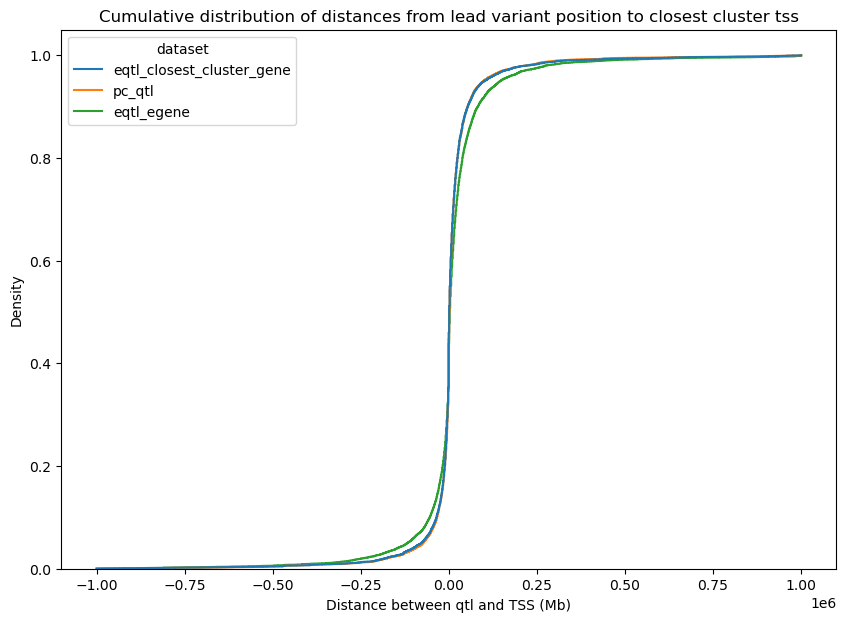

In [15]:
# plot all the closest in cluster genes together and zoom in on the middle a bit more
fig, ax = plt.subplots(figsize=(10,7))
sns.histplot(data=joined, x='clip_distance', hue='dataset', 
            stat='density', ax=ax, common_norm=False, element="step", fill=False,
            cumulative=True)
plt.xlabel('Distance between qtl and TSS (Mb)')
plt.title('Cumulative distribution of distances from lead variant position to closest cluster tss')


Text(0.5, 1.0, 'Cumulative distribution of distances from lead variant position to closest cluster tss')

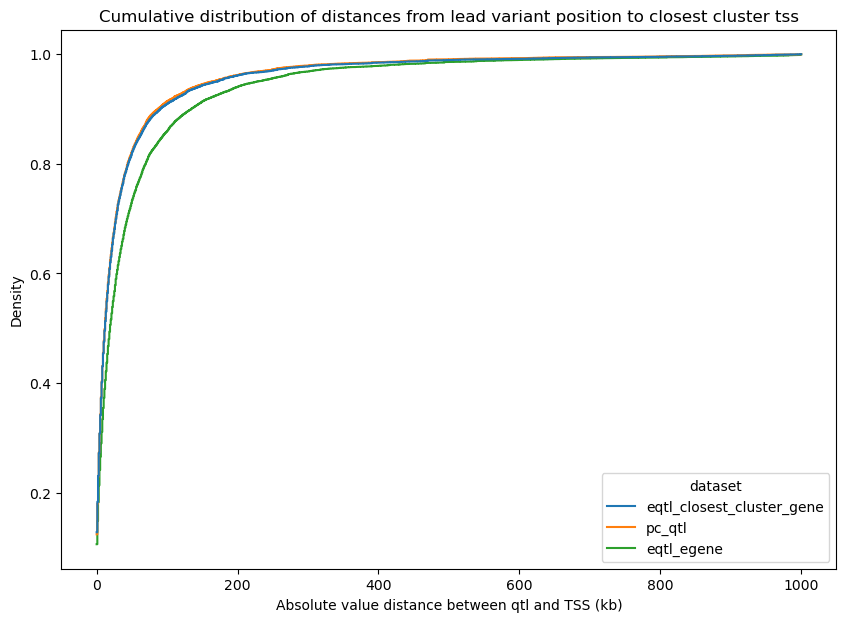

In [16]:
# absolute value of distance for that plot
fig, ax = plt.subplots(figsize=(10,7))
sns.histplot(data=joined, x='abs_clip_distance_kb', hue='dataset', 
            stat='density', ax=ax, common_norm=False, element="step", fill=False,
            cumulative=True, bins=1000)
plt.xlabel('Absolute value distance between qtl and TSS (kb)')
plt.title('Cumulative distribution of distances from lead variant position to closest cluster tss')

# broken up by pc number

In [17]:
# plotable distance for overlap df

overlap_df['clip_distance'] = overlap_df['cluster_min_distance'].clip(-1000000, 1000000)
overlap_df['abs_clip_distance_kb'] = overlap_df['clip_distance'].apply(abs)/1000


e_overlap_df['clip_egene_distance'] = e_overlap_df['egene_distance'].clip(-1000000, 1000000)
e_overlap_df['abs_clip_egene_distance_kb'] = e_overlap_df['clip_egene_distance'].apply(abs)/1000

overlap_df['clip_pc_num'] = overlap_df['pc_num'].clip(0,5)

/local/scratch/klawren/slrmtmp.46646254/ipykernel_19975/1146841988.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  e_overlap_df['clip_egene_distance'] = e_overlap_df['egene_distance'].clip(-1000000, 1000000)
/local/scratch/klawren/slrmtmp.46646254/ipykernel_19975/1146841988.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  e_overlap_df['abs_clip_egene_distance_kb'] = e_overlap_df['clip_egene_distance'].apply(abs)/1000


In [29]:
dark[0]

(0.538832724352575, 0.32764237607532753, 0.066564352862848)

([<matplotlib.lines.Line2D object at 0x2b315cd37e80>, <matplotlib.lines.Line2D object at 0x2b315d6341c0>], ['eqtl - closest gene', 'eqtl - egene'])


Text(0.5, 1.0, 'Cumulative distance distribution lead variant position to closest cluster tss by pc number')

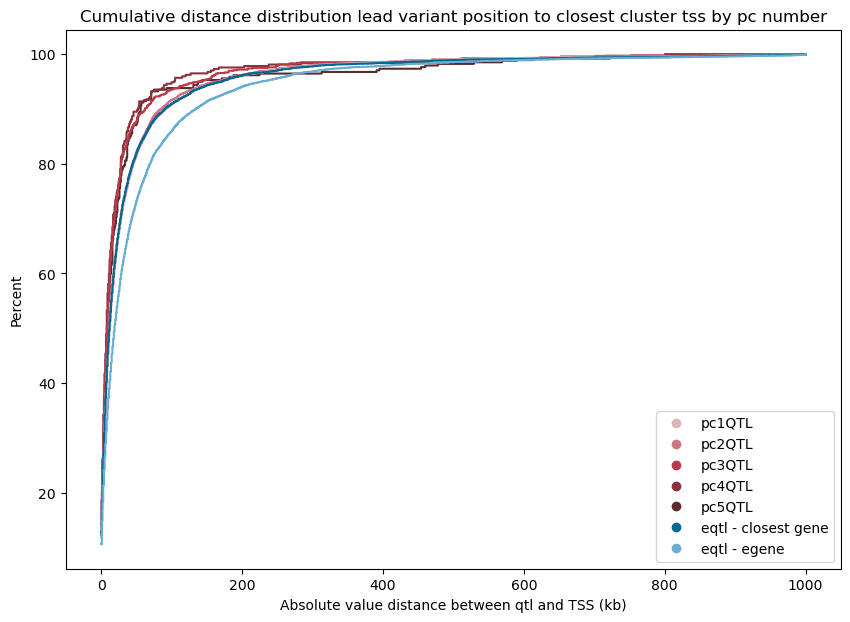

In [18]:
# clip the number of pcs
max_pcs = 5
overlap_df['clip_pc_num'] = overlap_df['pc_num'].clip(0,max_pcs)

# absolute value of distance for that plot
fig, ax = plt.subplots(figsize=(10,7))

# palette 
# palette 
root_color = '#B83A4B'
light = [sns.light_palette(root_color, n_colors=max_pcs/2+2)[-(i+1)] for i in range(int(max_pcs/2)+1)]
dark = [sns.dark_palette(root_color, n_colors=max_pcs/2+2, reverse=True)[i+1] for i in range(int(max_pcs/2))]
pc_pal = light[::-1] + dark

# plot the pcqtl distances 
p1 = sns.histplot(data=overlap_df, x='abs_clip_distance_kb', hue='clip_pc_num', 
            stat='percent', ax=ax, common_norm=False, element="step", fill=False,
            cumulative=True, bins=1000, palette=pc_pal[:max_pcs], hue_order=np.arange(1, max_pcs+1, 1))


# plot the eqtl distances for comparision
p2 = sns.histplot(data=overlap_df[overlap_df['orig_cs_dataset']=='control_eqtl'], x='abs_clip_distance_kb', color='#016895', 
            stat='percent', ax=ax, common_norm=False, element="step", fill=False,
            cumulative=True, label='eqtl - closest gene', bins=1000)

p3 = sns.histplot(data=e_overlap_df, x='abs_clip_egene_distance_kb', color='#67AFD2', 
            stat='percent', ax=ax, common_norm=False, element="step", fill=False,
            cumulative=True, label='eqtl - egene', bins=1000)

print(p1.get_legend_handles_labels())

# Get hue categories + colors

# Create manual legend
handles = [plt.Line2D([0,0],[1,1], color=c, marker='o', linestyle='') for c in pc_pal[:max_pcs]]
[handles.append(plt.Line2D([0,0],[1,1], color=c, marker='o', linestyle='')) for c in ['#016895','#67AFD2']]


# Set these handles as your current legend:
ax.legend(handles=handles, labels=[f'pc{i+1}QTL' for i in range(max_pcs)]+['eqtl - closest gene', 'eqtl - egene'])


# label the plot
plt.xlabel('Absolute value distance between qtl and TSS (kb)')
plt.title('Cumulative distance distribution lead variant position to closest cluster tss by pc number')


([<matplotlib.lines.Line2D object at 0x2b315e229670>, <matplotlib.lines.Line2D object at 0x2b315e229490>], ['eqtl - closest gene', 'eqtl - egene'])


Text(0.5, 1.0, 'Exclusive pcQTLs: cumulative distance distribution lead variant position to closest cluster tss')

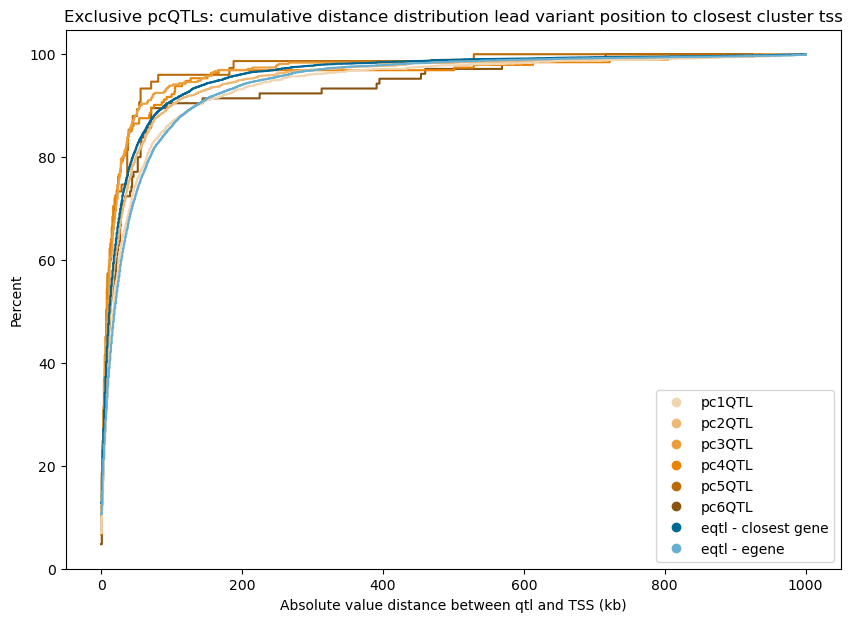

In [19]:

# clip the number of pcs
max_pcs = 6
overlap_df['clip_pc_num'] = overlap_df['pc_num'].clip(0,max_pcs)

# absolute value of distance for that plot
fig, ax = plt.subplots(figsize=(10,7))

# palette 
root_color = '#E98300'
light = [sns.light_palette(root_color, n_colors=max_pcs/2+2)[-(i+1)] for i in range(int(max_pcs/2)+1)]
dark = [sns.dark_palette(root_color, n_colors=max_pcs/2+2, reverse=True)[i+1] for i in range(int(max_pcs/2))]
pc_pal = light[::-1] + dark


# plot the pcqtl distances 
p1 = sns.histplot(data=overlap_df[overlap_df['num_e_overlap']==0], x='abs_clip_distance_kb', hue='clip_pc_num', 
            stat='percent', ax=ax, common_norm=False, element="step", fill=False,
            cumulative=True, bins=1000, palette=pc_pal[:max_pcs], hue_order=np.arange(1, max_pcs+1, 1))


# plot the eqtl distances for comparision
p2 = sns.histplot(data=overlap_df[overlap_df['orig_cs_dataset']=='control_eqtl'], x='abs_clip_distance_kb', color='#016895', 
            stat='percent', ax=ax, common_norm=False, element="step", fill=False,
            cumulative=True, label='eqtl - closest gene', bins=1000)

p3 = sns.histplot(data=e_overlap_df, x='abs_clip_egene_distance_kb', color='#67AFD2', 
            stat='percent', ax=ax, common_norm=False, element="step", fill=False,
            cumulative=True, label='eqtl - egene', bins=1000)

print(p1.get_legend_handles_labels())

# Get hue categories + colors

# Create manual legend
handles = [plt.Line2D([0,0],[1,1], color=c, marker='o', linestyle='') for c in pc_pal[:max_pcs]]
[handles.append(plt.Line2D([0,0],[1,1], color=c, marker='o', linestyle='')) for c in ['#016895','#67AFD2']]


# Set these handles as your current legend:
ax.legend(handles=handles, labels=[f'pc{i+1}QTL' for i in range(max_pcs)]+['eqtl - closest gene', 'eqtl - egene'])


# label the plot
plt.xlabel('Absolute value distance between qtl and TSS (kb)')
plt.title('Exclusive pcQTLs: cumulative distance distribution lead variant position to closest cluster tss')


([<matplotlib.lines.Line2D object at 0x2b315cef0ee0>, <matplotlib.lines.Line2D object at 0x2b315cc58af0>], ['eqtl - closest gene', 'eqtl - egene'])


Text(0.5, 1.0, 'Cluster > 2, exclusive pcqtls: cumulative distance distribution lead variant position to closest cluster tss')

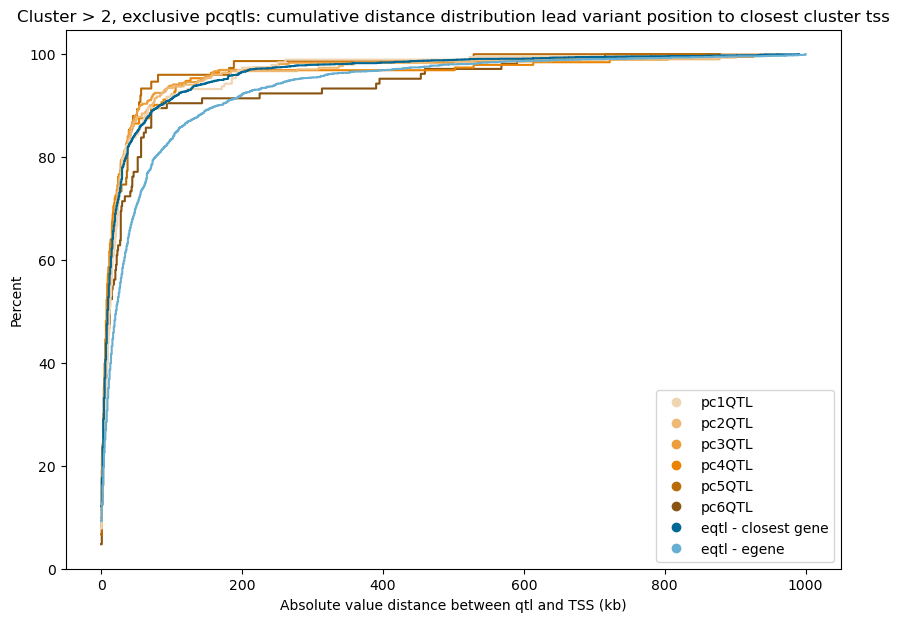

In [20]:

# larger clusters?
max_pcs = 6
overlap_df['clip_pc_num'] = overlap_df['pc_num'].clip(0,max_pcs)

# absolute value of distance for that plot
fig, ax = plt.subplots(figsize=(10,7))

# palette 
root_color = '#E98300'
light = [sns.light_palette(root_color, n_colors=max_pcs/2+2)[-(i+1)] for i in range(int(max_pcs/2)+1)]
dark = [sns.dark_palette(root_color, n_colors=max_pcs/2+2, reverse=True)[i+1] for i in range(int(max_pcs/2))]
pc_pal = light[::-1] + dark


# plot the pcqtl distances 
p1 = sns.histplot(data=overlap_df[(overlap_df['cluster_size']>2) & (overlap_df['num_e_overlap']==0)], x='abs_clip_distance_kb', hue='clip_pc_num', 
            stat='percent', ax=ax, common_norm=False, element="step", fill=False,
            cumulative=True, bins=1000, palette=pc_pal[:max_pcs], hue_order=np.arange(1, max_pcs+1, 1))


# plot the eqtl distances for comparision
p2 = sns.histplot(data=overlap_df[(overlap_df['cluster_size']>2) & (overlap_df['orig_cs_dataset']=='control_eqtl')], x='abs_clip_distance_kb', color='#016895', 
            stat='percent', ax=ax, common_norm=False, element="step", fill=False,
            cumulative=True, label='eqtl - closest gene', bins=1000)

p3 = sns.histplot(data=e_overlap_df[(e_overlap_df['cluster_size']>2)], x='abs_clip_egene_distance_kb', color='#67AFD2', 
            stat='percent', ax=ax, common_norm=False, element="step", fill=False,
            cumulative=True, label='eqtl - egene', bins=1000)

print(p1.get_legend_handles_labels())

# Get hue categories + colors

# Create manual legend
handles = [plt.Line2D([0,0],[1,1], color=c, marker='o', linestyle='') for c in pc_pal[:max_pcs]]
[handles.append(plt.Line2D([0,0],[1,1], color=c, marker='o', linestyle='')) for c in ['#016895','#67AFD2']]


# Set these handles as your current legend:
ax.legend(handles=handles, labels=[f'pc{i+1}QTL' for i in range(max_pcs)]+['eqtl - closest gene', 'eqtl - egene'])


# label the plot
plt.xlabel('Absolute value distance between qtl and TSS (kb)')
plt.title('Cluster > 2, exclusive pcqtls: cumulative distance distribution lead variant position to closest cluster tss')


([<matplotlib.lines.Line2D object at 0x2b315cdf5bb0>, <matplotlib.lines.Line2D object at 0x2b315cdf5c10>], ['eqtl - closest gene', 'eqtl - egene'])


Text(0.5, 1.0, 'Exclusive pcqtls: cumulative distance distribution lead variant position to closest cluster tss')

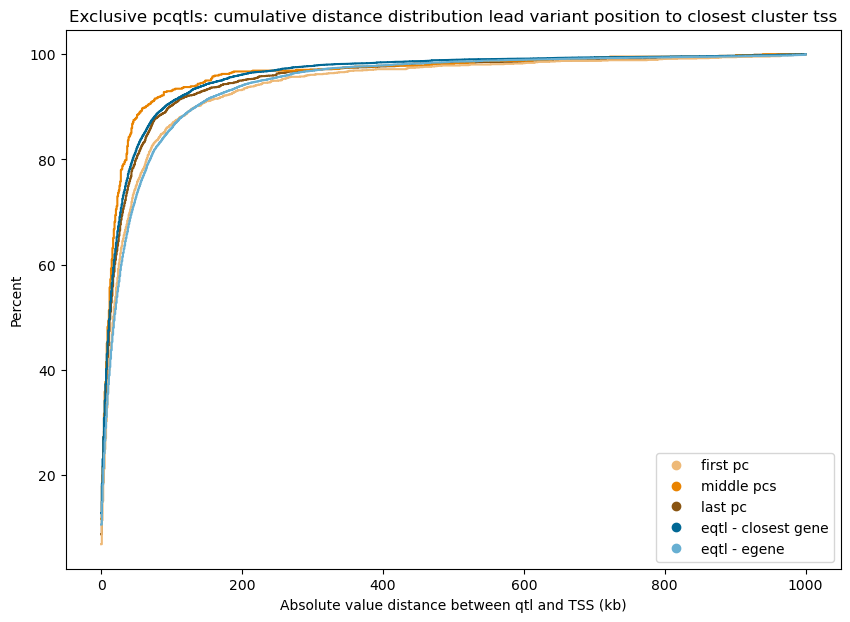

In [21]:
# split first, last, and middle pcs

overlap_df['pc_order'] = 'middle'
overlap_df.loc[overlap_df['pc_num'] == overlap_df['cluster_size'],'pc_order'] = 'last'
overlap_df.loc[overlap_df['pc_num'] == 1,'pc_order'] = 'first'


# absolute value of distance plot for pc seperated be first middle and last
fig, ax = plt.subplots(figsize=(10,7))

# palette 
root_color = '#E98300'
max_pcs=3
light = [sns.light_palette(root_color, n_colors=max_pcs/2+2)[-(i+1)] for i in range(int(max_pcs/2)+1)]
dark = [sns.dark_palette(root_color, n_colors=max_pcs/2+2, reverse=True)[i+1] for i in range(int(max_pcs/2))]
pc_pal = light[::-1] + dark


# plot the pcqtl distances 
p1 = sns.histplot(data=overlap_df[(overlap_df['num_e_overlap']==0)], x='abs_clip_distance_kb', hue='pc_order', 
            stat='percent', ax=ax, common_norm=False, element="step", fill=False,
            cumulative=True, bins=1000, palette=pc_pal[:3], hue_order=['first', 'middle', 'last'])


# plot the eqtl distances for comparision
p2 = sns.histplot(data=overlap_df[(overlap_df['orig_cs_dataset']=='control_eqtl')], x='abs_clip_distance_kb', color='#016895', 
            stat='percent', ax=ax, common_norm=False, element="step", fill=False,
            cumulative=True, label='eqtl - closest gene', bins=1000)

p3 = sns.histplot(data=e_overlap_df, x='abs_clip_egene_distance_kb', color='#67AFD2', 
            stat='percent', ax=ax, common_norm=False, element="step", fill=False,
            cumulative=True, label='eqtl - egene', bins=1000)

print(p1.get_legend_handles_labels())

# Get hue categories + colors

# Create manual legend
handles = [plt.Line2D([0,0],[1,1], color=c, marker='o', linestyle='') for c in pc_pal[:max_pcs]]
[handles.append(plt.Line2D([0,0],[1,1], color=c, marker='o', linestyle='')) for c in ['#016895','#67AFD2']]


# Set these handles as your current legend:
ax.legend(handles=handles, labels=['first pc', 'middle pcs', 'last pc', 'eqtl - closest gene', 'eqtl - egene'])


# label the plot
plt.xlabel('Absolute value distance between qtl and TSS (kb)')
plt.title('Exclusive pcqtls: cumulative distance distribution lead variant position to closest cluster tss')



## for the poster

In [26]:
# add in data for exclusively pc variants
exclusivepc_df = overlap_df[(overlap_df['num_e_overlap']==0)&(overlap_df['num_pc_overlap']>0)]
exclusivefirst_df = overlap_df[(overlap_df['num_e_overlap']==0)&(overlap_df['pc_order']=='first')]
exclusivemiddle_df = overlap_df[(overlap_df['num_e_overlap']==0)&(overlap_df['pc_order']=='middle')]
exclusivelast_df = overlap_df[(overlap_df['num_e_overlap']==0)&(overlap_df['pc_order']=='last')]

exclusivee_df = overlap_df[(overlap_df['num_e_overlap']>0)&(overlap_df['num_pc_overlap']==0)]


# a dataset that puts egenes in twice, once with a distance to their egene and once with a distance to the closest gene in the cluster
joined=pd.DataFrame({'distance': np.concatenate([overlap_df['cluster_min_distance'], 
                                                 e_overlap_df['egene_distance'], 
                                                 exclusivepc_df['cluster_min_distance'],
                                                 exclusivee_df['cluster_min_distance'], 
                                                 overlap_df[(overlap_df['num_e_overlap']==1)]['cluster_min_distance'], 
                                                 overlap_df[(overlap_df['num_e_overlap']>1)]['cluster_min_distance'],
                                                 exclusivefirst_df['cluster_min_distance'], 
                                                 exclusivemiddle_df['cluster_min_distance'], 
                                                 exclusivelast_df['cluster_min_distance']]), 
              'dataset':np.concatenate([overlap_df['orig_cs_dataset'], 
                                        pd.Series(['eqtl_egene_only']*len(e_overlap_df)), 
                                        pd.Series(['exclusive_pcqtl']*len(exclusivepc_df)),
                                        pd.Series(['exclusive_eqtl']*len(exclusivee_df)),
                                        pd.Series(['single_e']*sum((overlap_df['num_e_overlap']==1))),
                                        pd.Series(['multiple_e']*sum((overlap_df['num_e_overlap']>1))),
                                        pd.Series(['exclusive first pc']*len(exclusivefirst_df)),
                                        pd.Series(['exclusive middle pc']*len(exclusivemiddle_df)),
                                        pd.Series(['exclusive last pc']*len(exclusivelast_df))] )})
joined.loc[joined['dataset']=='control_eqtl','dataset'] ='eqtl_all_cluster_genes'
joined['abs_distance'] = joined['distance'].apply(abs)


In [36]:
mpl.rcParams['figure.dpi']= 1000


/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


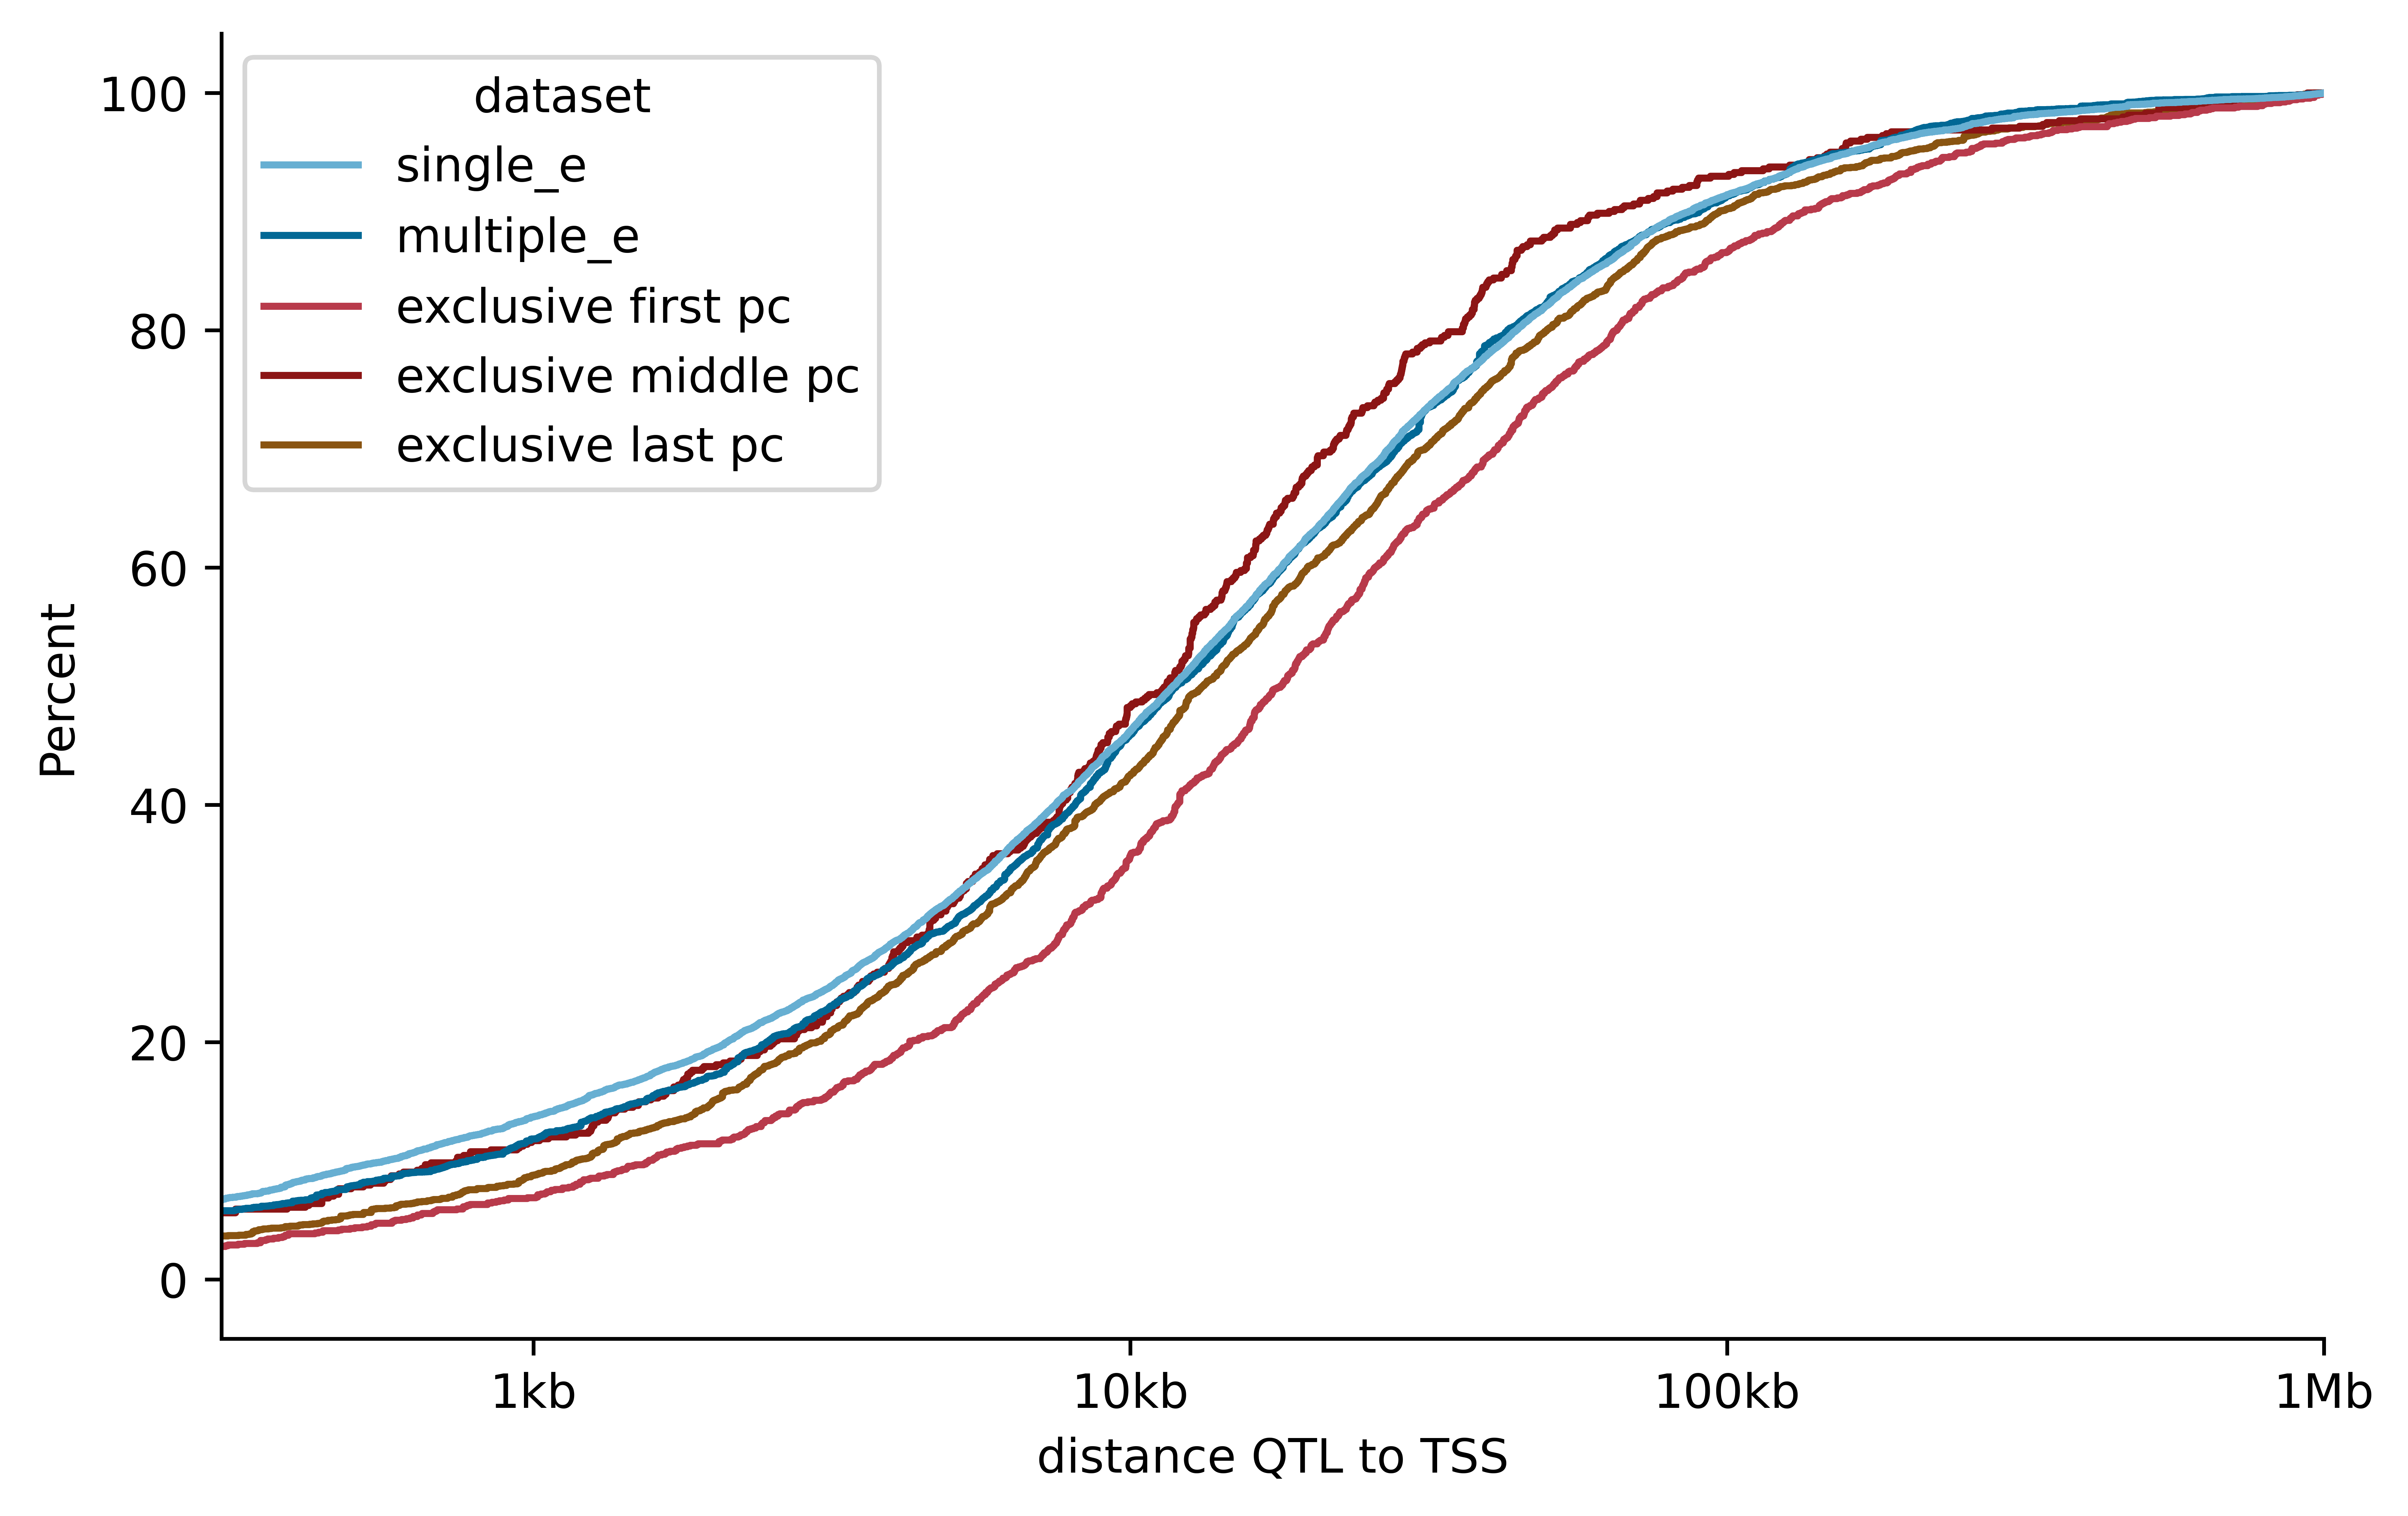

In [38]:

# further filter to just the categories for the poster
joined = joined[joined['dataset'].isin(['exclusive_pcqtl', 'multiple_e', 'single_e', 'exclusive first pc', 'exclusive middle pc', 'exclusive last pc'])]

xlim=1000000
joined['clip_distance'] = joined['distance'].clip(-xlim, xlim)
joined['abs_clip_distance_kb'] = np.log10(joined['clip_distance'].apply(abs))
fig, ax = plt.subplots(figsize=(8,5))
sns.histplot(data=joined, x='abs_clip_distance_kb', hue='dataset', 
            stat='percent', ax=ax, common_norm=False, element="step", fill=False,
            cumulative=True, 
            palette={'multiple_e':'#016895', 'single_e':'#67AFD2', 'exclusive first pc':'#B83A4B', 'exclusive middle pc':'#8C1515', 'exclusive last pc':dark[-1]},
            hue_order = ['single_e', 'multiple_e', 'exclusive first pc', 'exclusive middle pc', 'exclusive last pc'], 
            bins=10000)
plt.xlabel('distance QTL to TSS')
#plt.title('Cumulative distribution of QTL-TSS distances for lead variants')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

h, l = ax.get_legend_handles_labels()
#ax.legend(h, labels=['exclusive first pc', 'exclusive middle pc', 'exclusive last pc', 'multiple eQTL', 'single eQTL'], frameon=False)

# plt.axvline(np.log10(600))
# plt.axvline(np.log10(24000))
# plt.axvline(np.log10(125000))
# plt.axvline(np.log10(300000))

ax.set_ylim((ax.get_ylim()[0]-5, ax.get_ylim()[1]))
ax.set_xlim(np.log10(300), np.log10(xlim))

ax.set_xticks(np.log10([1000, 10000, 100000, 1000000]))
ax.set_xticklabels(['1kb', '10kb', '100kb', '1Mb'])



plt.show()